<a href="https://colab.research.google.com/github/Sabaudian/Neural_Conversational_Agents_project/blob/main/load_and_process_friends_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
# === Install === #
!pip install -q wordcloud


In [2]:
# === Imports === #
import os
import re
import nltk
import zipfile

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from os import listdir
from typing import Tuple
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from scipy.stats import gaussian_kde
from google.colab import drive, files
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split


In [ ]:
# === Constants & Set-Up === #
drive.mount(mountpoint="/content/drive", force_remount=True) # Mount Google Drive
DRIVE_BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks"    # Path to Drive main directory

# Kaggle
DATASET_ID = "blessondensil294/friends-tv-series-screenplay-script" # ID for Kaggle, format: 'dataset_owner_name/dataset_name'

# Directory & Paths
ROOT_DIR = os.getcwd()
DATASET_DIR = os.path.join(ROOT_DIR, "archive")                               # Path to dataset directory
DATA_DIR = os.path.join(DRIVE_BASE_DIR, "data")                               # Path to data directory
FRIENDS_DIR = os.path.join(DATA_DIR, "friends")                               # Path to friends directory
ZIP_PATH = os.path.join(ROOT_DIR, "friends-tv-series-screenplay-script.zip")  # Path to the zipped dataset

# Regex patterns
BRACKET_CONTENT_REGEX = r"\(.*\)"
SPECIAL_CHARACTERS_REGEX = r"[\/(){}\[\]\|@_#]|\\t|\\n"
ALLOWED_CHARACTERS_REGEX = r"[^.\',;:?!0-9a-zA-Z \-]"
PARENTHETICAL_REGEX = r"\([^)]*\)"
EXCLUDE_PATTERNS = [r".+'s .+"]

# Characters
MAIN_CHARACTERS = {"Rachel", "Phoebe", "Ross", "Chandler", "Monica", "Joey"}

# Selected characters to form dataset
SELESCTED_CHARACTERS = {"Joey", "Phoebe"}

# Download stopwords
nltk.download("stopwords")


In [ ]:
# === Define Working environment === #
def makedirs(dir_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Args:
        path: Path to the directory to be created.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"> Directory '{dir_path}' created.")
    else:
        print(f"> Directory '{dir_path}' already exists.")


# Create necessary directory
for dir_path in [DATA_DIR, FRIENDS_DIR]:
    makedirs(dir_path)


# Set-up Kaggle API and Download the dataset

#### Download Kaggle API Credentials:
1. Go to your [Kaggle account](https://www.kaggle.com/).
2. In the "API" section, click on "Create new API Token".
3. This will download a **kaggle.json** file to your computer.
4. Procede with the execution of following code.

In [ ]:
# Upload 'kaggle.json' file
files.upload()


In [ ]:
# Set-up kaggle
!ls -lha kaggle.json
!pip install -q --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd


In [ ]:
# rw access
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle


In [8]:
# List files in the dataset
!kaggle datasets files blessondensil294/friends-tv-series-screenplay-script


Next Page Token = CfDJ8KvMat0eHzhGoPokVBGB7D2ucc_n_r7jF9NCWBofhFN9uHuBhb1hOZtt4Szcz95TTsMz8igJuPN26BR6cqmv13c
name                                           size  creationDate                
--------------------------------------------  -----  --------------------------  
S01E01 Monica Gets A Roommate.txt             25434  2020-09-14 13:18:52.361000  
S01E02 The Sonogram At The End.txt            18430  2020-09-14 13:18:52.429000  
S01E03 The Thumb.txt                          19353  2020-09-14 13:18:52.425000  
S01E04 George Stephanopoulos.txt              20264  2020-09-14 13:18:52.422000  
S01E05 The East German Laundry Detergent.txt  19733  2020-09-14 13:18:52.477000  
S01E06 The Butt.txt                           18404  2020-09-14 13:18:52.571000  
S01E07 The Blackout.txt                       18975  2020-09-14 13:18:52.576000  
S01E08 Nana Dies Twice.txt                    17525  2020-09-14 13:18:52.542000  
S01E09 Underdog Gets Away.txt                 18124  2020-09-14 13:18:

In [9]:
# Download the dataset
!kaggle datasets download -d blessondensil294/friends-tv-series-screenplay-script


Dataset URL: https://www.kaggle.com/datasets/blessondensil294/friends-tv-series-screenplay-script
License(s): copyright-authors
  0% 0.00/1.92M [00:00<?, ?B/s]
100% 1.92M/1.92M [00:00<00:00, 260MB/s]


In [10]:
# Unzip the file
if os.path.exists(path=ZIP_PATH):
  # Unzip the file
  with zipfile.ZipFile(file=ZIP_PATH, mode="r") as actors_zip:
    actors_zip.extractall(path=DATASET_DIR)
    actors_zip.close()

  # Delete zip file
  os.remove(path=ZIP_PATH)

# Pre-processing the dataset

## Load dataset

In [11]:
# Load the dataset
def load_friends_dataset(path: str) -> pd.DataFrame:
    """
    Loads the Friends TV Script dataset from the given path.

    Args:
        path (str): dataset path.

    Returns:
        pd.DataFrame: dataframe.
    """
    rows = []
    # Documents number
    docs_num = len(listdir(path))
    # Documents name
    docs_name = listdir(path)

    # Loop over documents
    for i in tqdm_notebook(range(docs_num)):
        # file name with corresponding episodes link
        file_name = docs_name[i]
        # Episode ID and Title (e.g.: S01E01 'episode name')
        file_label = file_name[:-4]
        # Read the documents
        with open(os.path.join(path, file_name), encoding="utf-8") as f:
            # Loop over lines
            for script_line in f.readlines():
                row = {
                    "source": file_label,
                    "line": script_line,
                }
                rows.append(row)
    # Build dataframe
    df = pd.DataFrame(rows)

    return df


In [12]:
# Raw dataset
df = load_friends_dataset(path=DATASET_DIR)

print(f"\n> Dataframe view:\n {df.head()}")
print(f"\n> Dataframe Shape: {df.shape}")


  0%|          | 0/228 [00:00<?, ?it/s]


> Dataframe view:
                source                                               line
0  S06E08 Rosss Teeth                        The One With Ross’s Teeth\n
1  S06E08 Rosss Teeth          Written by: Perry Rein and Gigi McCreey\n
2  S06E08 Rosss Teeth                                                 \n
3  S06E08 Rosss Teeth                                                 \n
4  S06E08 Rosss Teeth  [Scene: Joey and Janine’s, Chandler knocks on ...

> Dataframe Shape: (140946, 2)


## Data processing

In [13]:
# Extracts valid characters
def extract_main_characters(character_str: str) -> list:
    """
    Extracts valid main characters from a noisy character string.

    Args:
        character_str (str): The raw character column string.

    Returns:
        list: A list of cleaned main character names that match MAIN_CHARACTERS.
    """
    # Remove parenthetical content and normalize casing
    cleaned = re.sub(PARENTHETICAL_REGEX, '', character_str, flags=re.IGNORECASE)
    cleaned = cleaned.replace("&", ",").replace("/", ",").replace(" and ", ",").replace(" to ", ",")
    parts = [part.strip().title() for part in cleaned.split(",")]

    result = []
    for name in parts:
        if name in MAIN_CHARACTERS:
            result.append(name)
        else:
            # Check if the part matches an exclusion pattern (e.g., "Joey's Doctor")
            if any(re.search(pat, name, re.IGNORECASE) for pat in EXCLUDE_PATTERNS):
                continue

    return result


# Processing the dataset
def process_friends_dataset(df: pd.DataFrame, min_line_length: int = 2) -> pd.DataFrame:
    """
    Cleans and processes the dataset containing dialogue lines from the Friends TV show.

    This function:
    - Removes non-dialogue lines and unwanted formatting
    - Extracts only lines spoken by the six main characters
    - Handles multiple characters speaking the same line
    - Cleans up action or descriptive text in character names

    Args:
        df (pd.DataFrame): The input dataframe with a 'line' column.
        min_line_length (int): Minimum number of characters allowed in a line.

    Returns:
        pd.DataFrame: A cleaned dataframe with 'line' and 'character' columns.
    """
    # Make a copy of the og. dataset
    df = df.copy()

    # Remove lines that start with brackets
    df = df[~df["line"].str.startswith(("[", "("))]

    # Strip whitespace
    df["line"] = df["line"].str.strip()

    # Remove parenthetical content from line
    df["line"] = df["line"].str.replace(BRACKET_CONTENT_REGEX, "", regex=True)

    # Replace special characters and clean up
    df["line"] = df["line"].str.replace(SPECIAL_CHARACTERS_REGEX, " ", regex=True)
    df["line"] = df["line"].str.replace(ALLOWED_CHARACTERS_REGEX, "", regex=True)

    # Remove empty or NaN lines
    df = df[df["line"].notna() & df["line"].str.strip().ne("")]

    # Split into character and actual spoken line
    df[["character_raw", "line"]] = df["line"].str.split(":", n=1, expand=True)

    # Further strip and filter
    df.replace(r"^\s*$", float("NaN"), regex=True, inplace=True)
    df.dropna(subset=["character_raw", "line"], inplace=True)
    df["character_raw"] = df["character_raw"].astype(str).str.strip()
    df["line"] = df["line"].astype(str).str.strip()

    df = df[df["line"].str.len() >= min_line_length]

    # Extract main characters
    df["character"] = df["character_raw"].apply(extract_main_characters)
    # Drop lines that have no valid character
    df = df[df["character"].map(len) > 0]
    # Explode into one row per character
    df = df.explode("character")

    # Normalize text for tone modeling
    df["line"] = df["line"].str.replace(r"[.!?]{2,}", ".", regex=True)  # clean repeated punctuation
    df["line"] = df["line"].str.replace(r"\s+", " ", regex=True).str.strip()  # clean whitespace

    # Final dataframe with 'line' first and 'character' second
    df = df[["line", "character"]].reset_index(drop=True)

    # Save to CSV
    csv_path = os.path.join(FRIENDS_DIR, "friends_dataset.csv")
    df.to_csv(path_or_buf=csv_path, index=False)
    print(f"> Processed Dataset saved at: {csv_path}")

    return df


In [14]:
# Processing the dataset
processed_df = process_friends_dataset(df=df)
print(f"\n> Processed Dataset View:\n {processed_df.head()}")


> Processed Dataset saved at: /content/drive/MyDrive/Colab_Notebooks/data/friends/friends_dataset.csv

> Processed Dataset View:
                                                 line character
0                                               Hey.      Joey
1  Hi, my names Chandler. I just moved in next do...  Chandler
2                         Sure, neighbor come on in.      Joey
3                              So, is Janine around?  Chandler
4                       Uh, no, shes at dance class.      Joey


In [15]:
# Plot text vs word count
def plot_text_length_distribution_friends(df: pd.DataFrame, max_words: int = 100) -> None:
    """
    Plots the distribution and KDE of word counts in the Friends dialogue dataset using Plotly.

    Args:
        df (pd.DataFrame): Processed DataFrame with a 'line' column.
        max_words (int): Maximum word count to display on the x-axis.
    """
    # Calculate word counts
    word_counts = df["line"].apply(lambda x: len(str(x).split())).tolist()
    bins = np.arange(0, max(word_counts) + 1)

    # KDE estimate
    kde = gaussian_kde(word_counts)
    x_kde = np.linspace(0, max(word_counts), 1000)
    y_kde = kde(x_kde)

    # Build Plotly figure
    fig = go.Figure()

    # Add histogram
    fig.add_trace(go.Histogram(
        x=word_counts,
        xbins=dict(start=0, end=max(word_counts), size=1),
        name="Histogram",
        marker=dict(
            color="cornflowerblue",
            line=dict(
                color="black",
                width=1.2
            )
        ),
    opacity=0.85
    ))

    # Add KDE line
    fig.add_trace(go.Scatter(
        x=x_kde,
        y=y_kde * len(word_counts),  # Scale KDE to match histogram frequency
        mode="lines",
        name="KDE",
        line=dict(color="crimson", width=2),
    ))

    # Layout
    fig.update_layout(
        title={
            "text": "<b>Distribution of Word Counts per Utterance</b>",
            "x": 0.5,
            "xanchor": "center",
            "font": dict(size=18, family="Arial", color="black", weight="bold"),
        },
        xaxis_title="Number of Words per Utterance",
        yaxis_title="Frequency",
        template="plotly",
        width=1000,
        height=700,
        legend=dict(
            title="Legend", font=dict(size=12),
            bordercolor="black", borderwidth=1
        ),
    )
    fig.update_xaxes(range=[0, max_words])
    fig.show()


In [16]:
# Text lenght distribution
plot_text_length_distribution_friends(df=processed_df)


## Plot Character Appearances

In [17]:
# Character Appearances
def plot_count_character_appearances(df: pd.DataFrame, main_characters: set) -> None:
    """
    Counts the number of times each main character appears in the 'character' column
    and plots a bar graph with the count of appearances for each character.

    Args:
        df (pd.DataFrame): The dataframe containing the character data.
        main_characters (set): A set of main character names to search in the dataframe.
    """
    # Colors
    colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8", "#FFC300", "#8D33FF"]

    # Dictionary to store counts
    character_counts = {character: 0 for character in main_characters}

    # Loop over each character and count the appearances
    for character in main_characters:
        # Count occurrences of the character in the 'character' column
        count = df[df["character"].str.contains(character, case=False, na=False)].shape[0]
        character_counts[character] = count

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    bars = plt.bar(character_counts.keys(), character_counts.values(), color=colors, edgecolor="black", linewidth=0.7)

    # Annotate each bar with its count value
    for bar in bars:
        y_val = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, y_val, str(y_val), ha="center", va="bottom", fontsize=12, fontweight="bold")

    plt.xlabel("Character", fontsize=12)
    plt.ylabel("Count of Appearances", fontsize=12)
    plt.title("Character Appearances in the Dataset", fontsize=14,  fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


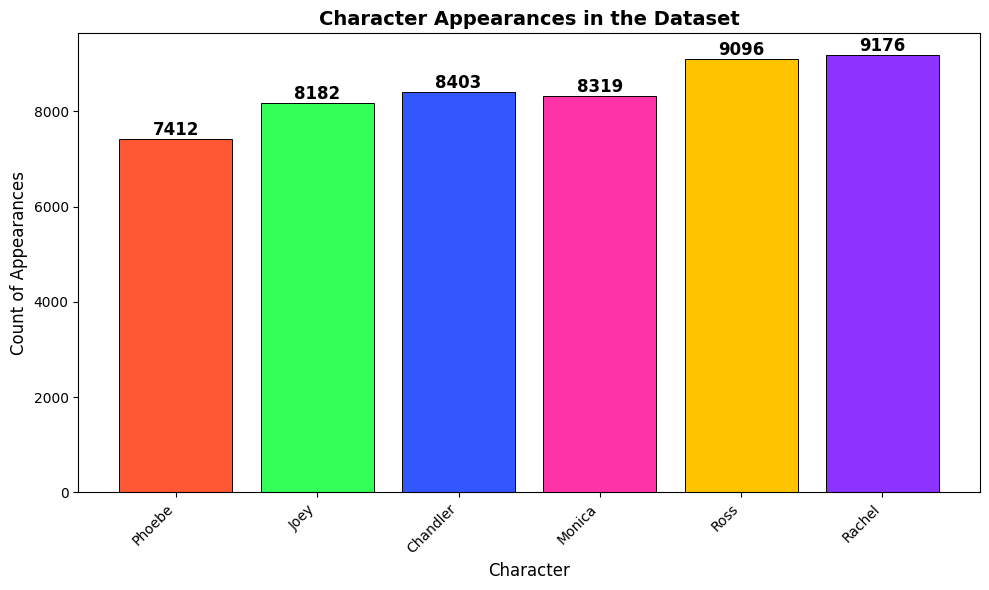

In [18]:
# Plot character appearances
plot_count_character_appearances(df=processed_df, main_characters=MAIN_CHARACTERS)


## Define dataset structure

In [19]:
# Define the response-context structure
def generate_character_context_csv(df: pd.DataFrame, character: str, context_size: int = 5) -> pd.DataFrame:
    """
    Filters the dataset for a selected character, structures it into response-context format,
    and saves it as a CSV file in a directory named after the selected character.

    Args:
        df (pd.DataFrame): Processed dataframe containing dialogue data.
        character (str): The character whose dialogues should be extracted.
        context_size (int, optional): The number of previous lines to include as context. Defaults to 5.
    Returns:
        pd.DataFrame: A processed dataframe containing dialogue data.
    """
    # Ensure character is in the main characters set
    if character not in MAIN_CHARACTERS:
        raise ValueError(f"Character '{character}' is not in the main character list: {MAIN_CHARACTERS}")

    # Get indices where the character speaks
    idx_character = df[df["character"] == character].index

    # Prepare rows for the new dataframe
    dataframe_rows = []
    columns = ["response"] + [f"context_{i}" for i in range(context_size)]

    for i in idx_character:
        row = [df["line"][i]]

        for j in range(0, context_size):
            line_idx = max(i - j - 1, 0)  # Ensure valid index
            row.append(df["line"][line_idx])

        dataframe_rows.append(row)

    # Build the new dataframe
    df = pd.DataFrame(dataframe_rows, columns=columns)

    # Save to csv
    character_dir = os.path.join(FRIENDS_DIR, character) # Build character's folder
    makedirs(dir_path=character_dir)

    csv_path = os.path.join(character_dir, f"{character}.csv") #
    df.to_csv(path_or_buf=csv_path, index=False)

    print(f" > CSV file saved at: {csv_path}\n")

    return df


In [20]:
# Response/Context data structure
for character in SELESCTED_CHARACTERS:
    print(f"> Define dataset for {character}...\n")
    context_df = generate_character_context_csv(df=processed_df, character=character)
    print(f"  > Context Dataset shape: {context_df.shape}\n")


> Define dataset for Phoebe...

> Directory '/content/drive/MyDrive/Colab_Notebooks/data/friends/Phoebe' already exists.
 > CSV file saved at: /content/drive/MyDrive/Colab_Notebooks/data/friends/Phoebe/Phoebe.csv

  > Context Dataset shape: (7412, 6)

> Define dataset for Joey...

> Directory '/content/drive/MyDrive/Colab_Notebooks/data/friends/Joey' already exists.
 > CSV file saved at: /content/drive/MyDrive/Colab_Notebooks/data/friends/Joey/Joey.csv

  > Context Dataset shape: (8182, 6)



In [21]:
print("> Joey dataset View: \n")
df = pd.read_csv(os.path.join(FRIENDS_DIR, "Joey", "Joey.csv"))
df.head()


> Joey dataset View: 



,response,context_0,context_1,context_2,context_3,context_4
0,Hey.,Hey.,Hey.,Hey.,Hey.,Hey.
1,"Sure, neighbor come on in.","Hi, my names Chandler. I just moved in next do...",Hey.,Hey.,Hey.,Hey.
2,"Uh, no, shes at dance class.","So, is Janine around?","Sure, neighbor come on in.","Hi, my names Chandler. I just moved in next do...",Hey.,Hey.
3,"Yeah, but, hey look, dont go through her stuff...",Can I check out what she did to my room?,"Uh, no, shes at dance class.","So, is Janine around?","Sure, neighbor come on in.","Hi, my names Chandler. I just moved in next do..."
4,It is.,Its spreading already.,"Yeah, but, hey look, dont go through her stuff...",Can I check out what she did to my room?,"Uh, no, shes at dance class.","So, is Janine around?"


In [22]:
# Slit Dataset
def split_dataset(df: pd.DataFrame, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits dataset into train, validation, and test sets with 80/10/10 ratio.

    Args:
        df: Input DataFrame.
        seed: Random seed for reproducibility.

    Returns:
        Tuple containing train, validation, and test DataFrames.
    """
    # First split — Train & Temp (Val + Test)
    train_set, temp_set = train_test_split(df, test_size=0.2, random_state=seed, shuffle=True)
    # Split Temp into Validation and Test
    valid_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=seed, shuffle=True)

    return train_set, valid_set, test_set


# Save All Splits to Disk
def save_splits(character:str, train_set, valid_set, test_set, base_dir: str) -> None:
    """
    Save the train, validation, and test sets to disk.

    Args:
        character: Character name.
        train_set: Train set DataFrame.
        valid_set: Validation set DataFrame.
        test_set: Test set DataFrame.
        base_dir: Base directory to save the data.
    """
    train_set.to_csv(os.path.join(base_dir, character, f"{character}_train.csv"), index=False)
    valid_set.to_csv(os.path.join(base_dir, character, f"{character}_valid.csv"), index=False)
    test_set.to_csv(os.path.join(base_dir, character, f"{character}_test.csv"), index=False)


In [23]:
# Split Dataset and Save to Disk
for character in SELESCTED_CHARACTERS:
  print(f"\n> Split dataset for {character}:")
  character_df = pd.read_csv(os.path.join(FRIENDS_DIR, character, f"{character}.csv"))

  train_set, valid_set, test_set = split_dataset(df=character_df)

  save_splits(
      character=character,
      train_set=train_set,
      valid_set=valid_set,
      test_set=test_set,
      base_dir=FRIENDS_DIR
  )

  print(f"  > Train Dataset shape: {train_set.shape}")
  print(f"  > Validation Dataset shape: {valid_set.shape}")
  print(f"  > Test Dataset shape: {test_set.shape}")



> Split dataset for Phoebe:
  > Train Dataset shape: (5929, 6)
  > Validation Dataset shape: (741, 6)
  > Test Dataset shape: (742, 6)

> Split dataset for Joey:
  > Train Dataset shape: (6545, 6)
  > Validation Dataset shape: (818, 6)
  > Test Dataset shape: (819, 6)


## Plot WordColud

In [24]:
# WordCloud
def plot_wordcloud(csv_path: str, min_sentence_length: int = 10) -> None:
    """
    Processes the 'response' column from a CSV file and generates a WordCloud.

    Args:
        csv_path (str): Path to the CSV file containing response-context data.
        min_sentence_length (int, optional): Minimum length of a valid sentence. Defaults to 3.
    Returns: None.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"The file '{csv_path}' does not exist.")

    df = pd.read_csv(csv_path)
    if "response" not in df.columns:
        raise ValueError("The CSV file must contain a 'response' column.")

    # Extract character name from filename (removes directory path and extension)
    character = os.path.splitext(os.path.basename(csv_path))[0]

    stopwords_set = set(stopwords.words("english"))
    processed_lines = []

    for response in df["response"].dropna():
        # Remove punctuation and multiple spaces
        response = re.sub(r"[^A-Za-z\s]", " ", response)
        response = re.sub(r"\s+", " ", response).strip()

        # Check sentence length and relevance
        words = response.split()
        if len(words) >= min_sentence_length and any(word.lower() not in stopwords_set for word in words):
            processed_lines.append(response)

    # Generate and plot WordCloud
    text = " ".join(processed_lines)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        stopwords=set(stopwords.words("english")),
        random_state=42,
    ).generate(text.lower())

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud of {character}")
    plt.show()



> Plot WordCloud for Phoebe:



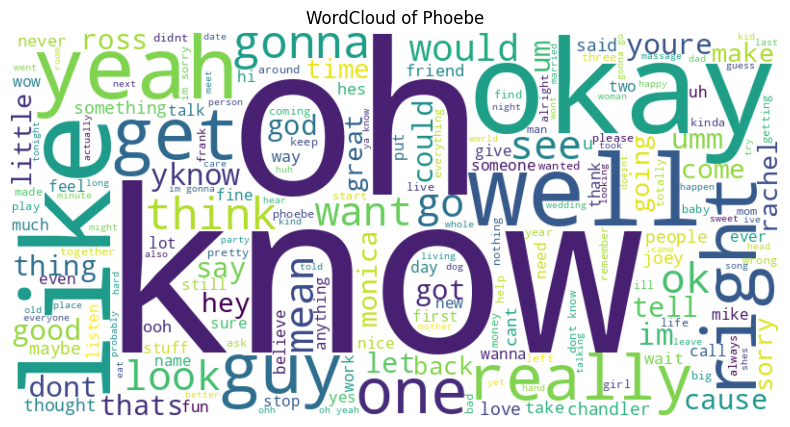


> Plot WordCloud for Joey:



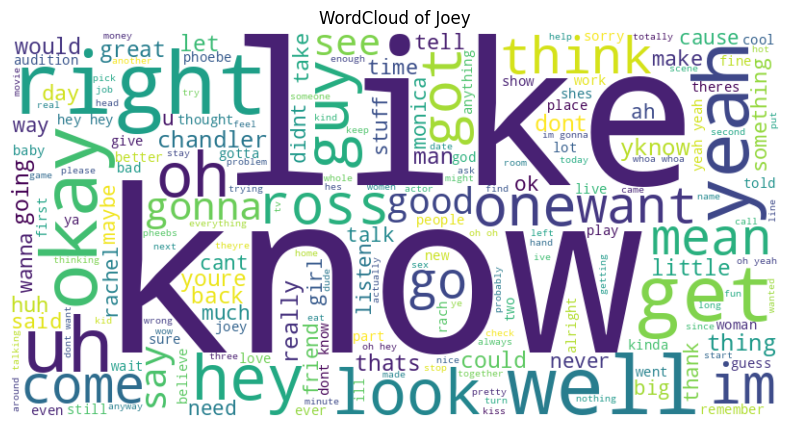

In [25]:
# WordCloud associated with the selected character
for selected_character in SELESCTED_CHARACTERS:
  print(f"\n> Plot WordCloud for {selected_character}:\n")
  csv_file_path = os.path.join(FRIENDS_DIR, selected_character, f"{selected_character}.csv")
  plot_wordcloud(csv_path=csv_file_path)
